In [1]:
# Mount drive in dsn folder

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Check the dsn folder

!ls '/content/drive/My Drive/dsn'

print('done...')

'dsn2019 (1).ipynb'   DSN.ipynb		       test.csv
 dsn2019.ipynb	      sample_submission2.csv   train.csv
done...


In [3]:
# Import the libraries

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

print('done...')

done...


In [4]:
# Read in the dataset and preview it
full_dataset=pd.read_csv("/content/drive/My Drive/dsn/train.csv")
full_dataset.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


## Slight Exploratory Data Analysis Plus comments

In [5]:
# Get a general feel of the data
full_dataset.info()
# Note that the 'qualification' has some missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38312 entries, 0 to 38311
Data columns (total 19 columns):
EmployeeNo                             38312 non-null object
Division                               38312 non-null object
Qualification                          36633 non-null object
Gender                                 38312 non-null object
Channel_of_Recruitment                 38312 non-null object
Trainings_Attended                     38312 non-null int64
Year_of_birth                          38312 non-null int64
Last_performance_score                 38312 non-null float64
Year_of_recruitment                    38312 non-null int64
Targets_met                            38312 non-null int64
Previous_Award                         38312 non-null int64
Training_score_average                 38312 non-null int64
State_Of_Origin                        38312 non-null object
Foreign_schooled                       38312 non-null object
Marital_Status                         383

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6f5da0ba8>,
      dtype=object)

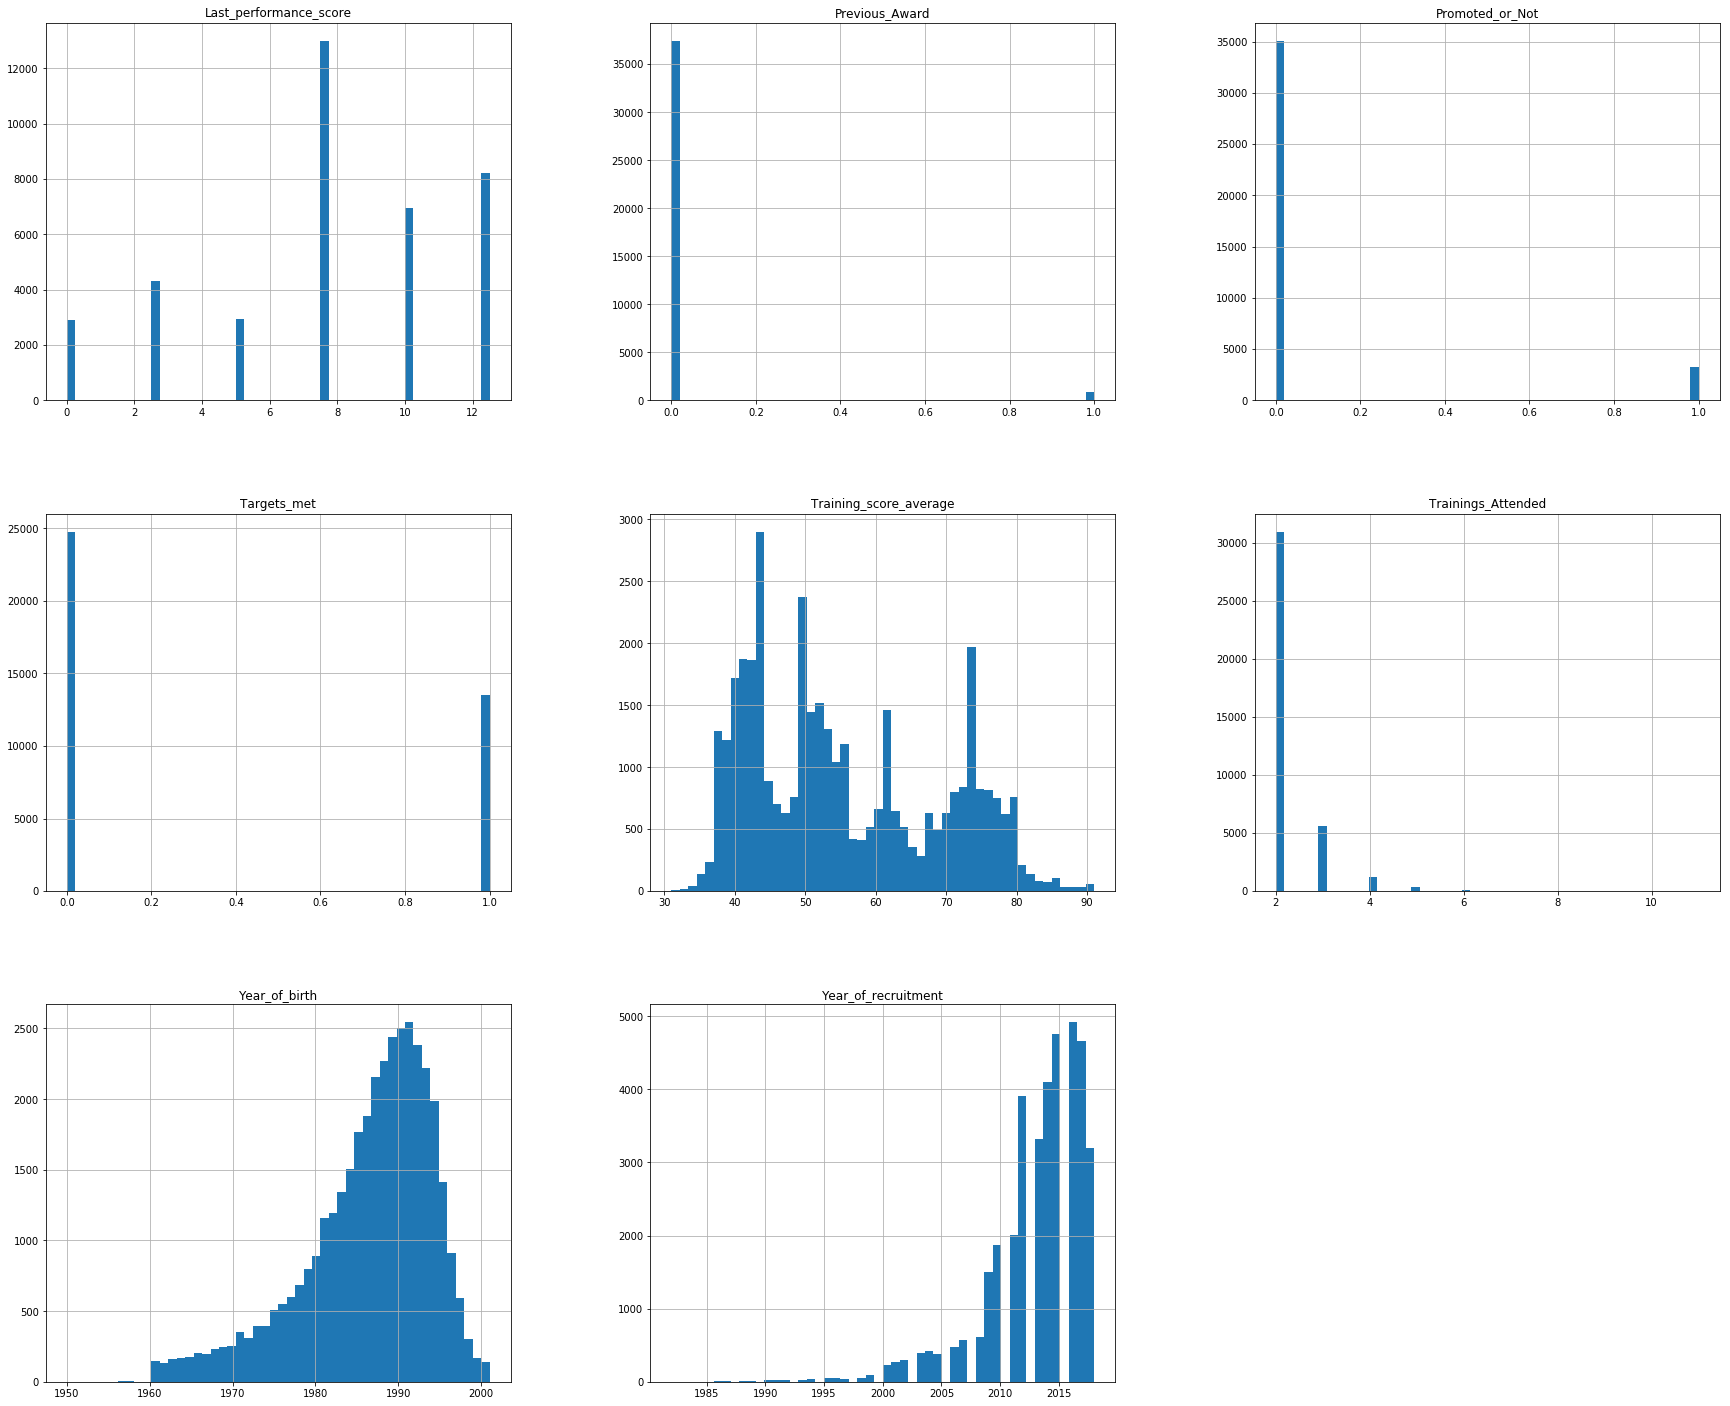

In [6]:
# visualise the buckets to see the distribution of the numerical data
full_dataset.hist(bins=50,figsize=(30,25))
# side-note convert the ages to respective buckets, there is an outlier that is older than 1960

In [7]:
# get a top-bottom statistical insight into the entire dataset
full_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Trainings_Attended,38312.0,2.253680,0.609443,2.0,2.0,2.0,2.0,11.0
Year_of_birth,38312.0,1986.209334,7.646047,1950.0,1982.0,1988.0,1992.0,2001.0
Last_performance_score,38312.0,7.698959,3.744135,0.0,5.0,7.5,10.0,12.5
Year_of_recruitment,38312.0,2013.139695,4.261451,1982.0,2012.0,2014.0,2016.0,2018.0
Targets_met,38312.0,0.352996,0.477908,0.0,0.0,0.0,1.0,1.0
Previous_Award,38312.0,0.023152,0.150388,0.0,0.0,0.0,0.0,1.0
Training_score_average,38312.0,55.366465,13.362741,31.0,43.0,52.0,68.0,91.0
Promoted_or_Not,38312.0,0.084595,0.278282,0.0,0.0,0.0,0.0,1.0


In [8]:
# check out the people who were born before 1960, since they are so few(12), we then turn them into category "people < 1960"
# the age is also normally distributed/slightly tail heavy,so there is no need for much transformation.
full_dataset[full_dataset['Year_of_birth']<1960].shape[0]
# min 1950   max 2001

12

In [0]:
# the year_of_recruitment is also all over the place, so it would make more sense to turn it into years spent at company
# then convert it to a categorical variable
# training_score_average is pretty good enough as is , so i really am better off leaving it as it is

In [10]:
full_dataset['No_of_previous_employers'].value_counts()

1              18867
0              13272
2               1918
3               1587
4               1324
5                943
More than 5      401
Name: No_of_previous_employers, dtype: int64

## Indepth Exploratory data analysis and Sidenotes

In [11]:
full_dataset.head(2)

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0


In [12]:
full_dataset['Marital_Status'].value_counts()
# turn any not-sure into Single to prevent our algorithm from learning garbage

Married     31022
Single       6927
Not_Sure      363
Name: Marital_Status, dtype: int64

In [13]:
full_dataset['Marital_Status'].value_counts()
# turn any not-sure into Single to prevent our algorithm from learning garbage

Married     31022
Single       6927
Not_Sure      363
Name: Marital_Status, dtype: int64

In [14]:
full_dataset['Trainings_Attended'].value_counts()
# since greater than 5 training is pretty few, i should consider making it anything>5 = 5

2     30981
3      5631
4      1244
5       316
6        93
7        28
8         6
10        5
11        4
9         4
Name: Trainings_Attended, dtype: int64

In [15]:
full_dataset['Channel_of_Recruitment'].value_counts()
# nothing here too. we just categorically encode them

Agency and others                  21310
Direct Internal process            16194
Referral and Special candidates      808
Name: Channel_of_Recruitment, dtype: int64

In [16]:
full_dataset['Gender'].value_counts()
# genders are fair, i guess. nothing much to see here, we just simply categorically encode it

Male      26880
Female    11432
Name: Gender, dtype: int64

In [17]:
full_dataset['Qualification'].value_counts()
# this seems pretty distributed too, but we categorically encode them wrt their level 3,2,1
# fill in missing values with Non-University Education

First Degree or HND         25578
MSc, MBA and PhD            10469
Non-University Education      586
Name: Qualification, dtype: int64

In [18]:
full_dataset['Division'].value_counts()
# pretty well distributed, no further engineering needed, simply categorically encoding them

Commercial Sales and Marketing                 11695
Customer Support and Field Operations           7973
Sourcing and Purchasing                         5052
Information Technology and Solution Support     4952
Information and Strategy                        3721
Business Finance Operations                     1786
People/HR Management                            1704
Regulatory and Legal services                    733
Research and Innovation                          696
Name: Division, dtype: int64

In [19]:
list(full_dataset)

['EmployeeNo',
 'Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'Trainings_Attended',
 'Year_of_birth',
 'Last_performance_score',
 'Year_of_recruitment',
 'Targets_met',
 'Previous_Award',
 'Training_score_average',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers',
 'Promoted_or_Not']

## Data Spliting

#### Split into Train,Testing and validation set (60%,25%,15%)

In [20]:
X=full_dataset.drop(['Promoted_or_Not'],1)
y=full_dataset['Promoted_or_Not']

print('done...')

done...


In [21]:
# split into train and test/validation
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.4, random_state=42)

# split into test and validation
X_test,X_validation,y_test,y_validation=train_test_split(X_test_valid,y_test_valid,test_size=0.375)

print('done...')

done...


In [22]:
# size of my batches of data
print("train size of rows:{} and columns:{}".format(*X_train.shape))
print("train size of rows:{} and columns:{}".format(*X_test.shape))
print("train size of rows:{} and columns:{}".format(*X_validation.shape))

train size of rows:22987 and columns:18
train size of rows:9578 and columns:18
train size of rows:5747 and columns:18


#### custom mappings we can use

In [0]:
qualification_to_number={'First Degree or HND':2, 'MSc, MBA and PhD':3, 'Non-University Education':1}

states_to_tribe={
    'ABIA': "IGBO",
    'ADAMAWA':"HAUSA",
    'AKWA IBOM':"IGBO",
    'ANAMBRA':"IGBO",
    'BAUCHI':"IGBO",
    'BAYELSA':"IGBO",
    'BENUE':"HAUSA",
    'BORNO':"HAUSA",
    'CROSS RIVER':"IGBO",
    'DELTA':"IGBO",
    'EBONYI':"IGBO",
    'EDO':"IGBO",
    'EKITI':"YORUBA",
    'ENUGU':"IGBO",
    'FCT':"HAUSA",
    'GOMBE':"HAUSA",
    'IMO':"IGBO",
    'JIGAWA':"HAUSA",
    'KADUNA':"HAUSA",
    'KANO':'HAUSA',
    'KATSINA':"HAUSA",
    'KEBBI':"HAUSA",
    'KOGI':"HAUSA",
    'KWARA':"HAUSA",
    "LAGOS":"YORUBA",
    'NASSARAWA':"HAUSA",
    'NIGER':"HAUSA",
     'OGUN':"YORUBA",
     'ONDO':"YORUBA",
     'OSUN':"YORUBA",
     'OYO':"YORUBA",
     'PLATEAU':"HAUSA",
     'RIVERS':"IGBO",
     'SOKOTO':"HAUSA",
     'TARABA':"HAUSA",
     'YOBE':"HAUSA",
     'ZAMFARA':"HAUSA"
    }

def bucket_age(year_of_birth):
    age=2019-int(year_of_birth)
    if age<21:
        return "less than 21"
    elif age>=21 and age<28:
        return "21-27"
    elif age>=28 and age<36:
        return "28-35"
    elif age>=36 and age<50:
        return "36-50"
    else:
        return "greater than 50"

def bucket_experience(year_of_exp):
    years_exp=2019-int(year_of_exp)
    if years_exp<5:
        return "1-4"
    elif years_exp>=5 and years_exp<10:
        return "5-9"
    elif years_exp>=10 and years_exp<15:
        return "10-14"
    elif years_exp>=15 and years_exp<20:
        return "15-20"
    else:
        return "greater than 20"

In [24]:
len(states_to_tribe)

37

## Specify my data transformations

In [25]:
from sklearn.base import BaseEstimator,TransformerMixin
full_dataset.head(10)

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0
5,YAK/S/00007,Customer Support and Field Operations,First Degree or HND,Female,Agency and others,2,1990,7.5,2014,0,0,51,ENUGU,Yes,Married,No,Yes,1,0
6,YAK/S/00008,Customer Support and Field Operations,"MSc, MBA and PhD",Male,Direct Internal process,2,1988,7.5,2013,0,0,55,OYO,No,Single,No,No,1,0
7,YAK/S/00009,Information and Strategy,First Degree or HND,Male,Agency and others,2,1993,10.0,2014,0,0,75,LAGOS,Yes,Married,No,No,0,0
8,YAK/S/00010,Commercial Sales and Marketing,"MSc, MBA and PhD",Male,Direct Internal process,2,1989,12.5,2014,1,0,46,ONDO,Yes,Married,No,No,0,0
9,YAK/S/00012,Commercial Sales and Marketing,First Degree or HND,Female,Direct Internal process,2,1986,12.5,2016,1,0,42,LAGOS,Yes,Married,No,No,0,1


In [26]:
qualification_binariser=LabelBinarizer()
not_biniarize=['Qualification',"Trainings_Attended","Last_performance_score","Training_score_average"]

def transform_data(input_dataset,is_training="true"):
    #firstsly drop the id column
#     input_data=input_data.drop(['EmployeeNo'],1)
    
    input_data=input_dataset.copy()
    #map the qualification
    input_data['Qualification']=input_data['Qualification'].fillna("Non-University Education")
    input_data['Qualification']=input_data['Qualification'].map(qualification_to_number)
    
    if is_training:       
        #Floor the trainings attended at 6
        input_data['Trainings_Attended']=input_data['Trainings_Attended'].map(lambda x: x if x<5 else 6)
    
    #roof the number of trainings attended at 5 for only training data i.e if the person has attended > 5 trainings make 5 to force the model to understand that 5 is a lot pf trainings
    if is_training:
        input_data['Qualification'].map(lambda x: 5 if x>5 else x )  
        
    #temporarily testing if bucketing the age is going to give me better data
    input_data['Year_of_birth']=input_data['Year_of_birth'].map(bucket_age)
    
    #temporarily testing if bucketing experience is going to help
    input_data['Year_of_recruitment']=input_data['Year_of_recruitment'].map(bucket_experience)
    
    #map the states respectively to the three geo zones
    input_data['State_Of_Origin']=full_dataset['State_Of_Origin'].map(lambda x:states_to_tribe.get(x,"YORUBA"))
    
    return input_data
  
print('done...')

done...
